# ⚠️ Auto-generated Notebook
    
This notebook is automatically compiled from source files in `/workspaces/awesome-matrix/src/examples/04_eigenvalues_eigenvectors`.
**Do not edit this file directly** as your changes will be overwritten.

To make changes:
1. Edit the source file `/workspaces/awesome-matrix/src/examples/04_eigenvalues_eigenvectors/02_power_iteration.py` instead
2. Run the compile script to regenerate this notebook

See [COMPILE.md](docs/COMPILE.md) for more information.


# Power Iteration Methods

In this notebook, we'll explore power iteration methods for computing eigenvalues and eigenvectors. These iterative algorithms are particularly useful for large, sparse matrices where direct computation methods are impractical.

## Why Power Iteration?

For large matrices (e.g., with dimensions in the thousands or millions), computing all eigenvalues and eigenvectors directly is computationally expensive. In many applications, we only need the dominant eigenvalue (the one with largest magnitude) and its corresponding eigenvector, or just a few of the largest eigenvalues.

Power iteration methods offer efficient ways to compute these without performing full eigendecomposition.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Set a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## The Basic Power Method

The power method is the simplest iterative technique for finding the dominant eigenvalue and eigenvector of a matrix. It works by repeatedly multiplying a vector by the matrix and normalizing the result.

### Algorithm:

1. Start with a random vector $\mathbf{v}_0$
2. Compute $\mathbf{w}_{k+1} = A\mathbf{v}_k$
3. Normalize: $\mathbf{v}_{k+1} = \mathbf{w}_{k+1} / \|\mathbf{w}_{k+1}\|$
4. Repeat steps 2-3 until convergence
5. The dominant eigenvalue is computed as: $\lambda = \mathbf{v}^T A \mathbf{v}$ (Rayleigh quotient)

Let's implement the basic power method:


In [2]:
def power_method(A, max_iterations=100, tol=1e-10, initial_vector=None):
    """
    Implement the power method to find the dominant eigenvalue and eigenvector.
    
    Args:
        A (torch.Tensor): A square matrix
        max_iterations (int): Maximum number of iterations to perform
        tol (float): Convergence tolerance
        initial_vector (torch.Tensor, optional): Initial guess for the eigenvector
        
    Returns:
        tuple: (dominant eigenvalue, dominant eigenvector, history of vectors, num iterations)
    """
    n = A.shape[0]
    
    # Initialize with a random vector if not provided
    if initial_vector is None:
        v = torch.randn(n)
    else:
        v = initial_vector.clone()
    
    # Normalize the initial vector
    v = v / torch.norm(v)
    
    # Store history for visualization
    vector_history = [v.clone()]
    eigenvalue_history = []
    
    # Perform iterations
    for i in range(max_iterations):
        # Apply the matrix
        w = A @ v
        
        # Compute eigenvalue estimate (Rayleigh quotient)
        eigenvalue = (v @ (A @ v)) / (v @ v)
        eigenvalue_history.append(eigenvalue.item())
        
        # Normalize
        v_new = w / torch.norm(w)
        
        # Store for visualization
        vector_history.append(v_new.clone())
        
        # Check convergence
        if torch.norm(v_new - v) < tol:
            v = v_new
            break
            
        # Update v for next iteration
        v = v_new
    
    # Compute final eigenvalue estimate
    eigenvalue = (v @ (A @ v)) / (v @ v)
    
    return eigenvalue, v, vector_history, eigenvalue_history, i+1


### Let's test the power method on a simple 2×2 matrix:


In [3]:
# Create a 2×2 matrix
A = torch.tensor([
    [5.0, 2.0],
    [2.0, 1.0]
])

print("Matrix A:")
print(A)

# Compute true eigenvalues and eigenvectors for comparison
true_eigenvalues, true_eigenvectors = torch.linalg.eig(A)

# Convert to real if eigenvalues are real
true_eigenvalues_imag = true_eigenvalues.imag
if torch.max(torch.abs(true_eigenvalues_imag)) < 1e-6:
    true_eigenvalues = true_eigenvalues.real
    true_eigenvectors = true_eigenvectors.real

# Sort by decreasing eigenvalue magnitude
idx = torch.argsort(torch.abs(true_eigenvalues), descending=True)
true_eigenvalues = true_eigenvalues[idx]
true_eigenvectors = true_eigenvectors[:, idx]

print("\nTrue eigenvalues (sorted by magnitude):")
for i, eigval in enumerate(true_eigenvalues):
    print(f"λ{i+1} = {eigval.item():.6f}")

print("\nTrue eigenvectors (as columns):")
print(true_eigenvectors)

# Run the power method
initial_v = torch.tensor([1.0, 0.0])  # Start with unit vector along x-axis
eigenvalue, eigenvector, vector_history, eigenvalue_history, num_iterations = power_method(
    A, max_iterations=20, initial_vector=initial_v)

print(f"\nPower method results after {num_iterations} iterations:")
print(f"Dominant eigenvalue: {eigenvalue.item():.6f}")
print(f"Corresponding eigenvector: {eigenvector}")

# Check if our eigenvector matches the true one (allowing for sign flip)
alignment = torch.abs(torch.dot(eigenvector, true_eigenvectors[:, 0]))
print(f"\nAlignment with true eigenvector: {alignment.item():.6f} (should be close to 1.0)")


Matrix A:
tensor([[5., 2.],
        [2., 1.]])

True eigenvalues (sorted by magnitude):
λ1 = 5.828427
λ2 = 0.171573

True eigenvectors (as columns):
tensor([[ 0.9239, -0.3827],
        [ 0.3827,  0.9239]])

Power method results after 6 iterations:
Dominant eigenvalue: 5.828427
Corresponding eigenvector: tensor([0.9239, 0.3827])

Alignment with true eigenvector: 1.000000 (should be close to 1.0)


### Visualizing Power Method Convergence

Let's visualize how the eigenvector estimate converges through iterations:


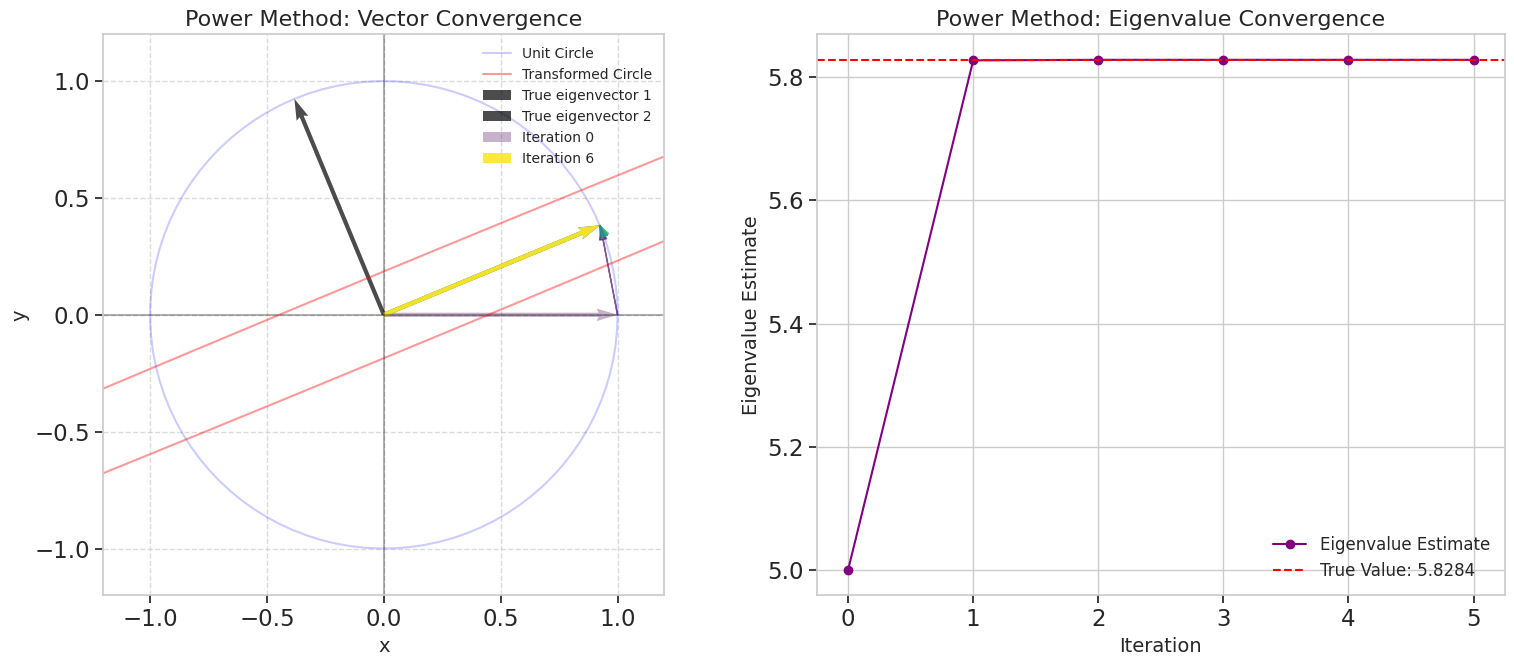

In [4]:
def visualize_power_method_2d(A, vector_history, eigenvalue_history, true_eigenvectors=None):
    """Visualize power method convergence in 2D."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot vector convergence
    ax1.set_xlim([-1.2, 1.2])
    ax1.set_ylim([-1.2, 1.2])
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Plot unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    ax1.plot(np.cos(theta), np.sin(theta), 'b-', alpha=0.2, label='Unit Circle')
    
    # Plot transformed circle
    circle_vectors = np.vstack([np.cos(theta), np.sin(theta)])
    transformed_vectors = A @ torch.tensor(circle_vectors, dtype=torch.float32)
    ax1.plot(transformed_vectors[0, :], transformed_vectors[1, :], 'r-', alpha=0.4, 
            label='Transformed Circle')
    
    # Plot true eigenvectors if provided
    if true_eigenvectors is not None:
        for i in range(true_eigenvectors.shape[1]):
            v = true_eigenvectors[:, i]
            ax1.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                      color='black', alpha=0.7, linestyle='-',
                      label=f'True eigenvector {i+1}')
    
    # Plot vector history with color gradient
    colors = plt.cm.viridis(np.linspace(0, 1, len(vector_history)))
    for i, v in enumerate(vector_history[:-1]):  # Exclude the last vector
        # Draw line from current to next
        ax1.arrow(v[0], v[1], 
                 vector_history[i+1][0]-v[0], vector_history[i+1][1]-v[1],
                 head_width=0.03, head_length=0.05, fc=colors[i], ec=colors[i], 
                 alpha=0.6, length_includes_head=True)
    
    # Also plot the vectors themselves
    for i, v in enumerate(vector_history):
        alpha = 0.3 + 0.7*i/len(vector_history)  # Fade in
        if i == 0 or i == len(vector_history)-1 or i % 5 == 0:
            ax1.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                     color=colors[i], alpha=alpha,
                     label=f'Iteration {i}' if i == 0 or i == len(vector_history)-1 else None)
    
    ax1.set_title('Power Method: Vector Convergence', fontsize=16)
    ax1.set_xlabel('x', fontsize=14)
    ax1.set_ylabel('y', fontsize=14)
    ax1.legend(loc='upper right', fontsize=10)
    ax1.set_aspect('equal')
    
    # Plot eigenvalue convergence
    ax2.plot(range(len(eigenvalue_history)), eigenvalue_history, 'o-', 
             color='purple', label='Eigenvalue Estimate')
    if true_eigenvectors is not None:
        ax2.axhline(y=true_eigenvalues[0].item(), color='r', linestyle='--', 
                   label=f'True Value: {true_eigenvalues[0].item():.4f}')
    
    ax2.set_title('Power Method: Eigenvalue Convergence', fontsize=16)
    ax2.set_xlabel('Iteration', fontsize=14)
    ax2.set_ylabel('Eigenvalue Estimate', fontsize=14)
    ax2.grid(True)
    ax2.legend(fontsize=12)
    
    plt.tight_layout()
    return fig

# Visualize the convergence
visualize_power_method_2d(A, vector_history, eigenvalue_history, true_eigenvectors)
plt.show()


### Creating an Animation of the Power Method


In [5]:
def create_power_method_animation(A, vector_history):
    """Create an animation of the power method iterations."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Setup axes and background elements
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Plot unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'b-', alpha=0.2, label='Unit Circle')
    
    # Plot transformed circle
    circle_vectors = np.vstack([np.cos(theta), np.sin(theta)])
    transformed_vectors = A @ torch.tensor(circle_vectors, dtype=torch.float32)
    ax.plot(transformed_vectors[0, :], transformed_vectors[1, :], 'r-', alpha=0.4, 
            label='Transformed Circle')
    
    # Plot true eigenvectors
    true_evals, true_evecs = torch.linalg.eigh(A)
    for i in range(true_evecs.shape[1]):
        v = true_evecs[:, i]
        ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, 
                 color='black', alpha=0.7, linestyle='-',
                 label=f'True eigenvector {i+1}')
    
    ax.set_title('Power Method Iteration: 0', fontsize=16)
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_aspect('equal')
    
    # Create quivers for current vector and history
    current_vector = ax.quiver(0, 0, vector_history[0][0], vector_history[0][1], 
                              angles='xy', scale_units='xy', scale=1, 
                              color='green', alpha=1.0, label='Current Vector')
    
    # Create scatter points for history
    history_points = ax.scatter([], [], c=[], cmap='viridis', alpha=0.5, s=30)
    
    # Animation update function
    def update(frame):
        # Update title
        ax.set_title(f'Power Method Iteration: {frame}', fontsize=16)
        
        # Update current vector
        current_vector.set_UVC(vector_history[frame][0], vector_history[frame][1])
        
        # Update history points
        if frame > 0:
            x_history = [v[0].item() for v in vector_history[:frame]]
            y_history = [v[1].item() for v in vector_history[:frame]]
            colors = np.linspace(0, 1, frame)
            
            history_points.set_offsets(np.column_stack([x_history, y_history]))
            history_points.set_array(colors)
        
        return current_vector, history_points
    
    anim = FuncAnimation(fig, update, frames=len(vector_history), interval=400, blit=False)
    plt.close()  # Prevent double display
    
    return HTML(anim.to_jshtml())

# Create animation
animation = create_power_method_animation(A, vector_history)
animation


## Inverse Power Method

While the power method finds the eigenvalue with the largest magnitude, the **inverse power method** helps us find the eigenvalue with the smallest magnitude.

### Algorithm:

1. Apply the power method to $A^{-1}$ instead of $A$
2. If $\lambda$ is an eigenvalue of $A$ with eigenvector $\mathbf{v}$, then $1/\lambda$ is an eigenvalue of $A^{-1}$ with the same eigenvector

However, computing the inverse is expensive. Instead, we can solve the system $A \mathbf{x} = \mathbf{v}$ in each iteration:


In [6]:
def inverse_power_method(A, max_iterations=100, tol=1e-10, initial_vector=None):
    """
    Implement the inverse power method to find the eigenvalue with smallest magnitude.
    
    Args:
        A (torch.Tensor): A square matrix
        max_iterations (int): Maximum number of iterations to perform
        tol (float): Convergence tolerance
        initial_vector (torch.Tensor, optional): Initial guess for the eigenvector
        
    Returns:
        tuple: (smallest eigenvalue, corresponding eigenvector, history of vectors, 
                eigenvalue history, number of iterations)
    """
    n = A.shape[0]
    
    # Initialize with a random vector if not provided
    if initial_vector is None:
        v = torch.randn(n)
    else:
        v = initial_vector.clone()
    
    # Normalize the initial vector
    v = v / torch.norm(v)
    
    # Store history for visualization
    vector_history = [v.clone()]
    eigenvalue_history = []
    
    # Perform iterations
    for i in range(max_iterations):
        try:
            # Solve the linear system A*w = v
            w = torch.linalg.solve(A, v)
        except RuntimeError:
            # If matrix is singular, add a small perturbation
            perturbed_A = A + 1e-6 * torch.eye(A.shape[0])
            w = torch.linalg.solve(perturbed_A, v)
        
        # Compute eigenvalue estimate (Rayleigh quotient)
        eigenvalue = (v @ (A @ v)) / (v @ v)
        eigenvalue_history.append(eigenvalue.item())
        
        # Normalize
        v_new = w / torch.norm(w)
        
        # Store for visualization
        vector_history.append(v_new.clone())
        
        # Check convergence
        if torch.norm(v_new - v) < tol:
            v = v_new
            break
            
        # Update v for next iteration
        v = v_new
    
    # Compute final eigenvalue estimate
    eigenvalue = (v @ (A @ v)) / (v @ v)
    
    return eigenvalue, v, vector_history, eigenvalue_history, i+1


### Let's test the inverse power method on a matrix with well-separated eigenvalues:


Matrix B:
tensor([[4., 1.],
        [1., 3.]])

True eigenvalues (sorted by magnitude):
λ1 = 2.381966
λ2 = 4.618034

True eigenvectors (as columns):
tensor([[-0.5257,  0.8507],
        [ 0.8507,  0.5257]])

Inverse power method results after 20 iterations:
Smallest eigenvalue: 2.381966
Corresponding eigenvector: tensor([-0.5257,  0.8507])

Alignment with true eigenvector: 1.000000 (should be close to 1.0)


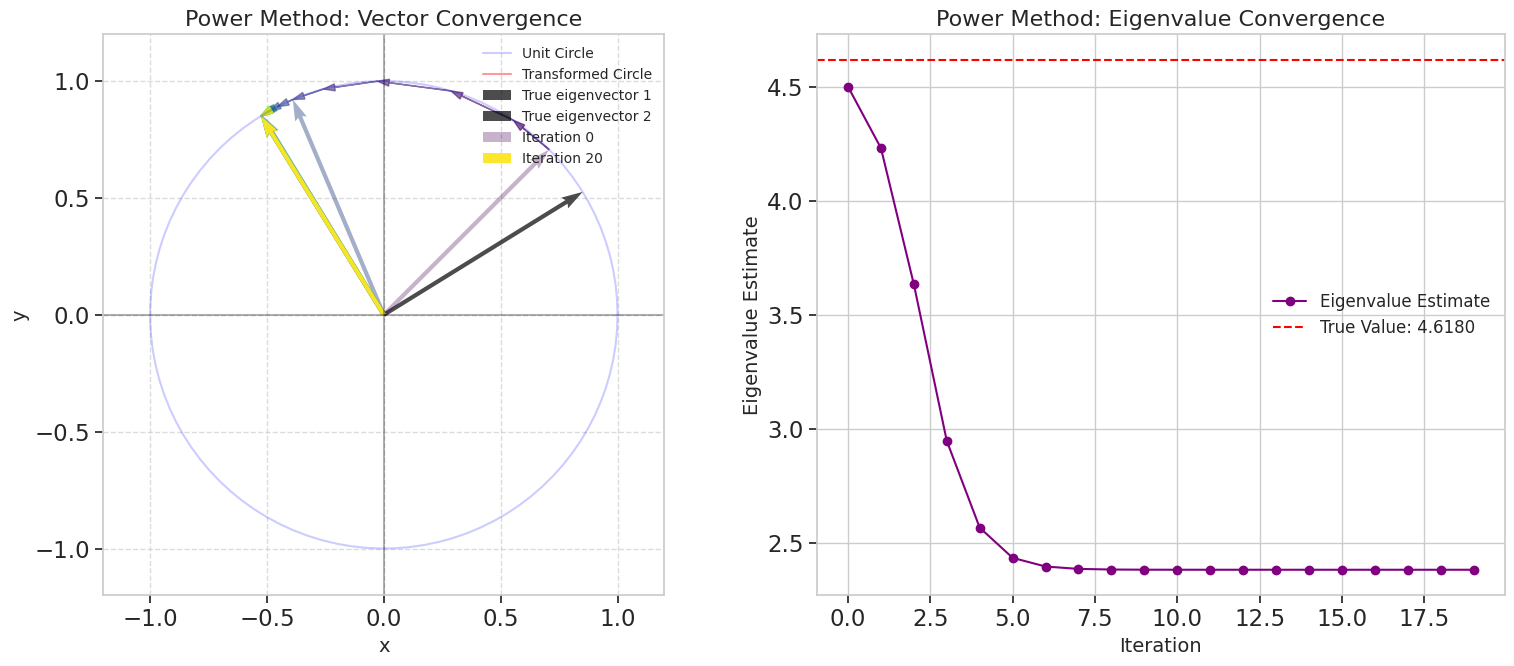

In [7]:
# Create a matrix with well-separated eigenvalues
B = torch.tensor([
    [4.0, 1.0],
    [1.0, 3.0]
])

print("Matrix B:")
print(B)

# Compute true eigenvalues and eigenvectors for comparison
true_eigenvalues, true_eigenvectors = torch.linalg.eig(B)

# Convert to real if eigenvalues are real
true_eigenvalues_imag = true_eigenvalues.imag
if torch.max(torch.abs(true_eigenvalues_imag)) < 1e-6:
    true_eigenvalues = true_eigenvalues.real
    true_eigenvectors = true_eigenvectors.real

# Sort by increasing eigenvalue magnitude
idx = torch.argsort(torch.abs(true_eigenvalues))
true_eigenvalues_sorted = true_eigenvalues[idx]
true_eigenvectors_sorted = true_eigenvectors[:, idx]

print("\nTrue eigenvalues (sorted by magnitude):")
for i, eigval in enumerate(true_eigenvalues_sorted):
    print(f"λ{i+1} = {eigval.item():.6f}")

print("\nTrue eigenvectors (as columns):")
print(true_eigenvectors_sorted)

# Run the inverse power method
initial_v = torch.tensor([1.0, 1.0])  # Start with a (1,1) vector
eigenvalue, eigenvector, vector_history, eigenvalue_history, num_iterations = inverse_power_method(
    B, max_iterations=20, initial_vector=initial_v)

print(f"\nInverse power method results after {num_iterations} iterations:")
print(f"Smallest eigenvalue: {eigenvalue.item():.6f}")
print(f"Corresponding eigenvector: {eigenvector}")

# Check if our eigenvector matches the true one (allowing for sign flip)
alignment = torch.abs(torch.dot(eigenvector, true_eigenvectors_sorted[:, 0]))
print(f"\nAlignment with true eigenvector: {alignment.item():.6f} (should be close to 1.0)")

# Visualize convergence
visualize_power_method_2d(B, vector_history, eigenvalue_history, true_eigenvectors_sorted)
plt.show()


## Shifted Power Method

What if we want to find an eigenvalue that is neither the largest nor the smallest in magnitude? The **shifted power method** can help us find eigenvalues near a specific value $\sigma$.

### Algorithm:

1. Apply the inverse power method to $(A - \sigma I)$ instead of $A$
2. If $\lambda$ is an eigenvalue of $A$, then $\lambda - \sigma$ is an eigenvalue of $(A - \sigma I)$
3. The inverse power method will find the eigenvalue of $(A - \sigma I)$ closest to 0, which corresponds to the eigenvalue of $A$ closest to $\sigma$

Let's implement the shifted power method:


In [8]:
def shifted_power_method(A, shift, max_iterations=100, tol=1e-10, initial_vector=None):
    """
    Implement the shifted power method to find the eigenvalue closest to shift.
    
    Args:
        A (torch.Tensor): A square matrix
        shift (float): The shift value (target eigenvalue)
        max_iterations (int): Maximum number of iterations to perform
        tol (float): Convergence tolerance
        initial_vector (torch.Tensor, optional): Initial guess for the eigenvector
        
    Returns:
        tuple: (eigenvalue, eigenvector, history of vectors, eigenvalue history, 
                number of iterations)
    """
    n = A.shape[0]
    I = torch.eye(n)
    A_shifted = A - shift * I
    
    # Run inverse power method on the shifted matrix
    inv_eigenvalue, eigenvector, vector_history, inv_eigenvalue_history, num_iterations = (
        inverse_power_method(A_shifted, max_iterations, tol, initial_vector))
    
    # Calculate actual eigenvalue
    eigenvalue = inv_eigenvalue + shift
    eigenvalue_history = [ev + shift for ev in inv_eigenvalue_history]
    
    return eigenvalue, eigenvector, vector_history, eigenvalue_history, num_iterations


### Now let's create a 3×3 matrix with three distinct eigenvalues and use the shifted power method to find the "middle" eigenvalue:


In [9]:
# Create a 3×3 matrix with three distinct eigenvalues
C = torch.tensor([
    [2.0, 1.0, 0.0],
    [1.0, 3.0, 1.0],
    [0.0, 1.0, 4.0]
])

print("Matrix C:")
print(C)

# Compute true eigenvalues and eigenvectors
true_eigenvalues, true_eigenvectors = torch.linalg.eig(C)

# Convert to real if eigenvalues are real
true_eigenvalues_imag = true_eigenvalues.imag
if torch.max(torch.abs(true_eigenvalues_imag)) < 1e-6:
    true_eigenvalues = true_eigenvalues.real
    true_eigenvectors = true_eigenvectors.real

# Sort eigenvalues
idx = torch.argsort(true_eigenvalues)
true_eigenvalues = true_eigenvalues[idx]
true_eigenvectors = true_eigenvectors[:, idx]

print("\nTrue eigenvalues (sorted):")
for i, eigval in enumerate(true_eigenvalues):
    print(f"λ{i+1} = {eigval.item():.6f}")

print("\nTrue eigenvectors (as columns):")
print(true_eigenvectors)

# Select the middle eigenvalue as our target
middle_eigenvalue = true_eigenvalues[1].item()
print(f"\nTarget eigenvalue (middle): {middle_eigenvalue:.6f}")

# Choose a shift value near the middle eigenvalue
# For demonstration, we'll intentionally not use the exact value
# Choose a shift that's not exactly on an eigenvalue to avoid singular matrices
shift = 2.9  # Near, but not exactly the middle eigenvalue
print(f"Using shift value: {shift}")

# Run the shifted power method
initial_v = torch.tensor([1.0, 1.0, 1.0])  # Equal weight to all directions
eigenvalue, eigenvector, vector_history, eigenvalue_history, num_iterations = shifted_power_method(
    C, shift, max_iterations=50, initial_vector=initial_v)

print(f"\nShifted power method results after {num_iterations} iterations:")
print(f"Found eigenvalue: {eigenvalue.item():.6f}")
print(f"Corresponding eigenvector: {eigenvector}")

# Check which true eigenvalue we found
distances = [torch.abs(eigenvalue - ev).item() for ev in true_eigenvalues]
closest_idx = np.argmin(distances)
print(f"\nClosest true eigenvalue: λ{closest_idx+1} = {true_eigenvalues[closest_idx].item():.6f}")
print(f"Distance: {distances[closest_idx]:.10f}")

# Check if our eigenvector matches the true one (allowing for sign flip)
alignment = torch.abs(torch.dot(eigenvector, true_eigenvectors[:, closest_idx]))
print(f"Alignment with true eigenvector: {alignment.item():.6f} (should be close to 1.0)")


Matrix C:
tensor([[2., 1., 0.],
        [1., 3., 1.],
        [0., 1., 4.]])

True eigenvalues (sorted):
λ1 = 1.267949
λ2 = 2.999999
λ3 = 4.732050

True eigenvectors (as columns):
tensor([[-0.7887, -0.5774,  0.2113],
        [ 0.5774, -0.5774,  0.5774],
        [-0.2113,  0.5774,  0.7887]])

Target eigenvalue (middle): 2.999999
Using shift value: 2.9

Shifted power method results after 8 iterations:
Found eigenvalue: 3.000000
Corresponding eigenvector: tensor([ 0.5774,  0.5774, -0.5774])

Closest true eigenvalue: λ2 = 2.999999
Distance: 0.0000009537
Alignment with true eigenvector: 1.000000 (should be close to 1.0)


### Visualizing Shifted Power Method Convergence

Let's visualize the convergence of eigenvalues in the shifted power method:


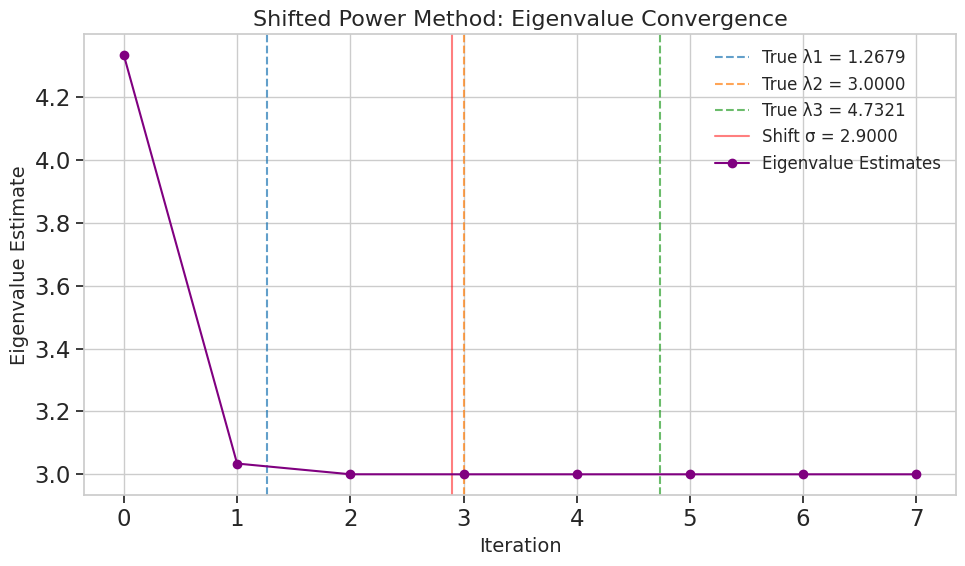

In [10]:
plt.figure(figsize=(10, 6))

# Plot all eigenvalues as vertical lines
for i, ev in enumerate(true_eigenvalues):
    plt.axvline(x=ev.item(), color=f'C{i}', linestyle='--', alpha=0.7,
               label=f'True λ{i+1} = {ev.item():.4f}')

# Plot the shift value
plt.axvline(x=shift, color='red', linestyle='-', alpha=0.5, 
           label=f'Shift σ = {shift:.4f}')

# Plot eigenvalue estimates through iterations
plt.plot(range(len(eigenvalue_history)), eigenvalue_history, 'o-',
         color='purple', label='Eigenvalue Estimates')

plt.title('Shifted Power Method: Eigenvalue Convergence', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Eigenvalue Estimate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Rayleigh Quotient Iteration

The Rayleigh Quotient Iteration (RQI) is a powerful refinement of the shifted power method where the shift is updated in each iteration to be the Rayleigh quotient of the current approximation. This accelerates convergence dramatically.

### Algorithm:

1. Start with an initial vector $\mathbf{v}_0$ and compute $\rho_0 = \frac{\mathbf{v}_0^T A \mathbf{v}_0}{\mathbf{v}_0^T \mathbf{v}_0}$
2. In each iteration:
   a. Solve $(A - \rho_k I) \mathbf{w}_{k+1} = \mathbf{v}_k$
   b. Normalize: $\mathbf{v}_{k+1} = \mathbf{w}_{k+1} / \|\mathbf{w}_{k+1}\|$
   c. Update: $\rho_{k+1} = \frac{\mathbf{v}_{k+1}^T A \mathbf{v}_{k+1}}{\mathbf{v}_{k+1}^T \mathbf{v}_{k+1}}$
3. Repeat until convergence

Let's implement RQI:


In [11]:
def rayleigh_quotient_iteration(A, max_iterations=100, tol=1e-10, initial_vector=None):
    """
    Implement Rayleigh Quotient Iteration to find an eigenvalue and eigenvector.
    
    Args:
        A (torch.Tensor): A square matrix
        max_iterations (int): Maximum number of iterations to perform
        tol (float): Convergence tolerance
        initial_vector (torch.Tensor, optional): Initial guess for the eigenvector
        
    Returns:
        tuple: (eigenvalue, eigenvector, history of vectors, eigenvalue history, 
                number of iterations)
    """
    n = A.shape[0]
    I = torch.eye(n)
    
    # Initialize with a random vector if not provided
    if initial_vector is None:
        v = torch.randn(n)
    else:
        v = initial_vector.clone()
    
    # Normalize the initial vector
    v = v / torch.norm(v)
    
    # Compute initial Rayleigh quotient
    rho = (v @ (A @ v)) / (v @ v)
    
    # Store history for visualization
    vector_history = [v.clone()]
    eigenvalue_history = [rho.item()]
    
    # Perform iterations
    for i in range(max_iterations):
        # Compute the shifted matrix
        A_shifted = A - rho * I
        
        try:
            # Solve the linear system (A - rho*I)w = v
            w = torch.linalg.solve(A_shifted, v)
        except:
            # If singular or near-singular matrix, add small perturbation
            print(f"Warning: Near-singular matrix at iteration {i+1}. Adding perturbation.")
            A_shifted = A_shifted + 1e-10 * I
            w = torch.linalg.solve(A_shifted, v)
        
        # Normalize
        v_new = w / torch.norm(w)
        
        # Update Rayleigh quotient
        rho_new = (v_new @ (A @ v_new)) / (v_new @ v_new)
        
        # Store for visualization
        vector_history.append(v_new.clone())
        eigenvalue_history.append(rho_new.item())
        
        # Check convergence
        if torch.abs(rho_new - rho) < tol:
            v = v_new
            rho = rho_new
            break
            
        # Update v and rho for next iteration
        v = v_new
        rho = rho_new
    
    return rho, v, vector_history, eigenvalue_history, i+1


### Let's compare the convergence of RQI with the shifted power method on our 3×3 matrix:


In [12]:
# Run RQI on the 3×3 matrix
initial_v = torch.tensor([1.0, 1.0, 1.0])  # Equal weight to all directions
eigenvalue_rqi, eigenvector_rqi, vector_history_rqi, eigenvalue_history_rqi, num_iterations_rqi = (
    rayleigh_quotient_iteration(C, max_iterations=10, initial_vector=initial_v))

print(f"RQI results after {num_iterations_rqi} iterations:")
print(f"Found eigenvalue: {eigenvalue_rqi.item():.6f}")
print(f"Corresponding eigenvector: {eigenvector_rqi}")

# Check which true eigenvalue we found
distances = [torch.abs(eigenvalue_rqi - ev).item() for ev in true_eigenvalues]
closest_idx = np.argmin(distances)
print(f"\nClosest true eigenvalue: λ{closest_idx+1} = {true_eigenvalues[closest_idx].item():.6f}")
print(f"Distance: {distances[closest_idx]:.10f}")

# Check if our eigenvector matches the true one (allowing for sign flip)
alignment = torch.abs(torch.dot(eigenvector_rqi, true_eigenvectors[:, closest_idx]))
print(f"Alignment with true eigenvector: {alignment.item():.6f} (should be close to 1.0)")


RQI results after 5 iterations:
Found eigenvalue: 4.732051
Corresponding eigenvector: tensor([-0.2113, -0.5774, -0.7887])

Closest true eigenvalue: λ3 = 4.732050
Distance: 0.0000009537
Alignment with true eigenvector: 1.000000 (should be close to 1.0)


### Comparing Convergence Rates

Let's compare how quickly the different methods converge:


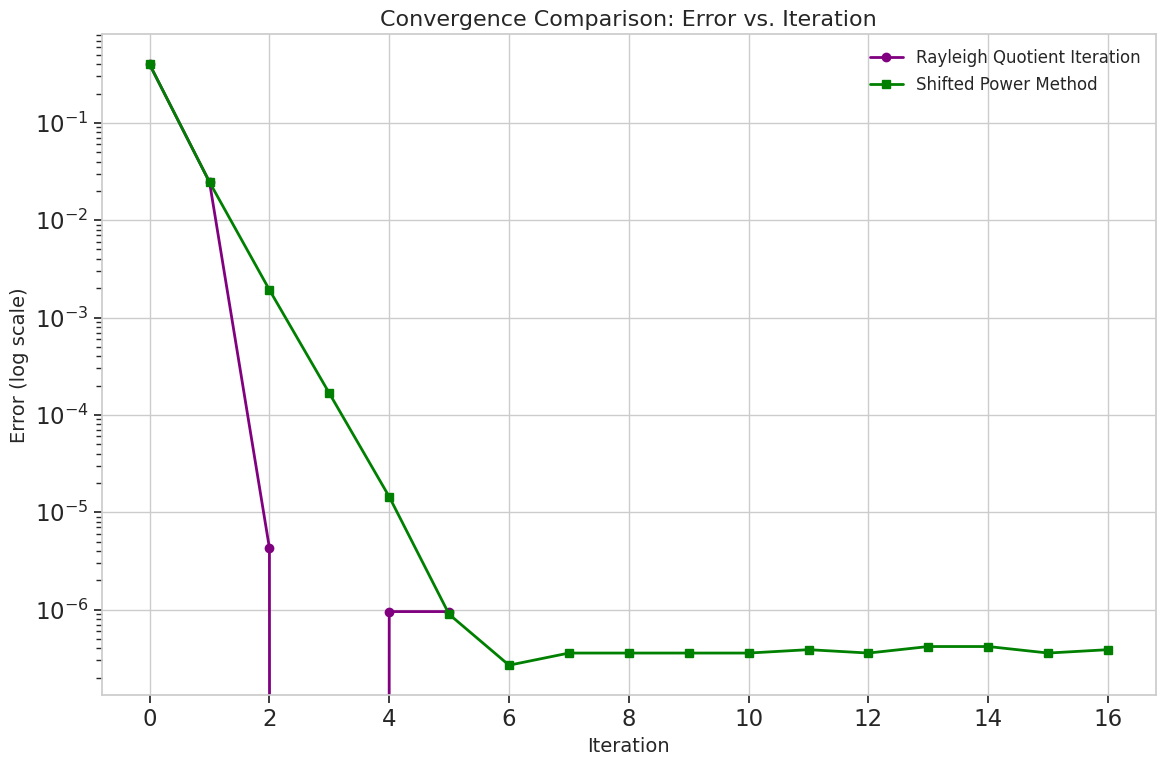

In [13]:
# Run shifted power method on the 3×3 matrix with a shift near the same eigenvalue
# For a fair comparison, we'll use the first eigenvalue approximation from RQI as our shift
shift_target = eigenvalue_history_rqi[0]
eigenvalue_shifted, eigenvector_shifted, vector_history_shifted, eigenvalue_history_shifted, num_iterations_shifted = (
    shifted_power_method(C, shift_target, max_iterations=30, initial_vector=initial_v))

# Prepare for plotting
plt.figure(figsize=(12, 8))

# Plot the convergence of the Rayleigh quotient iteration
plt.semilogy(range(len(eigenvalue_history_rqi)), 
         [abs(x - true_eigenvalues[closest_idx].item()) for x in eigenvalue_history_rqi], 
         'o-', color='purple', linewidth=2, label='Rayleigh Quotient Iteration')

# Plot the convergence of the shifted power method
plt.semilogy(range(len(eigenvalue_history_shifted)), 
         [abs(x - true_eigenvalues[closest_idx].item()) for x in eigenvalue_history_shifted], 
         's-', color='green', linewidth=2, label='Shifted Power Method')

plt.title('Convergence Comparison: Error vs. Iteration', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Error (log scale)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## Practical Considerations and Tips

When using iterative methods for eigenvalue computation, keep these tips in mind:

1. **Convergence Rate**:
   - The basic power method converges at a linear rate, proportional to the ratio of the second largest to the largest eigenvalue in magnitude.
   - The inverse power method converges at a rate proportional to the ratio of the second smallest to the smallest eigenvalue in magnitude.
   - RQI has cubic convergence once it gets close to an eigenvalue, making it extremely fast in the final iterations.

2. **Initial Vector Choice**:
   - Random initialization is often sufficient.
   - If you have a rough idea of the eigenvector, starting close to it accelerates convergence.
   - To avoid accidental orthogonality to the target eigenvector, ensure your initial vector has non-zero projection onto all eigenvectors.

3. **Shift Selection**:
   - For the shifted power method, the closer your shift is to an eigenvalue, the faster the convergence.
   - If multiple eigenvalues are close to your shift, the method might alternate between them before eventually converging.

4. **Deflation Techniques**:
   - After finding one eigenvalue-eigenvector pair $(λ, v)$, you can use deflation to find additional eigenvalues.
   - One approach is to work with the matrix $A - λvv^T$ which has the same eigenvalues as $A$ except that $λ$ is replaced by 0.

## Applications

Power iteration methods are used in numerous applications:

1. **Google's PageRank Algorithm**:
   - The original PageRank used power iteration to find the dominant eigenvector of the web graph adjacency matrix.

2. **Principal Component Analysis (PCA)**:
   - Power iteration can find the first few principal components without computing the full eigendecomposition.

3. **Vibration Analysis**:
   - In mechanical engineering, power methods can locate specific resonant frequencies.

4. **Quantum Mechanics**:
   - Finding the ground state energy of a Hamiltonian matrix often involves finding its smallest eigenvalue.

5. **Computer Graphics**:
   - Spectral mesh processing uses eigenvalues and eigenvectors of the Laplacian matrix.


## Implementing a Simple PCA using Power Iteration

Let's demonstrate how to perform PCA using power iteration to find the top principal components:


In [14]:
def power_iteration_pca(X, n_components=2, max_iterations=100, tol=1e-10):
    """
    Implement PCA using power iteration to find the top n principal components.
    
    Args:
        X (torch.Tensor): Data matrix of shape (n_samples, n_features)
        n_components (int): Number of principal components to compute
        max_iterations (int): Maximum number of iterations for power method
        tol (float): Convergence tolerance
        
    Returns:
        tuple: (components, explained_variance)
    """
    # Center the data
    X_centered = X - X.mean(dim=0, keepdim=True)
    
    # Compute covariance matrix
    n_samples = X.shape[0]
    cov = (X_centered.T @ X_centered) / (n_samples - 1)
    
    components = []
    explained_variance = []
    
    # Deflated covariance matrix
    cov_deflated = cov.clone()
    
    for i in range(n_components):
        # Use power method to find dominant eigenvector
        eigenvalue, eigenvector, _, _, _ = power_method(
            cov_deflated, max_iterations=max_iterations, tol=tol)
        
        # Store component and variance
        components.append(eigenvector)
        explained_variance.append(eigenvalue.item())
        
        # Deflate covariance matrix to remove this component
        # This creates a matrix with the same eigenvalues except the one we found is replaced by 0
        cov_deflated = cov_deflated - eigenvalue * torch.outer(eigenvector, eigenvector)
    
    # Stack components into a matrix
    components = torch.stack(components)
    
    return components, explained_variance


### Let's apply this to a synthetic dataset:


Principal components found by power iteration PCA:
tensor([[ 0.6999,  0.7143],
        [ 0.7143, -0.6999]])

Explained variance:
[1.6834354400634766, 0.1966446042060852]

Principal components found by SVD:
tensor([[ 0.6999,  0.7143],
        [ 0.7143, -0.6999]])

Singular values squared:
[1.683435474464554, 0.19664454030130574]


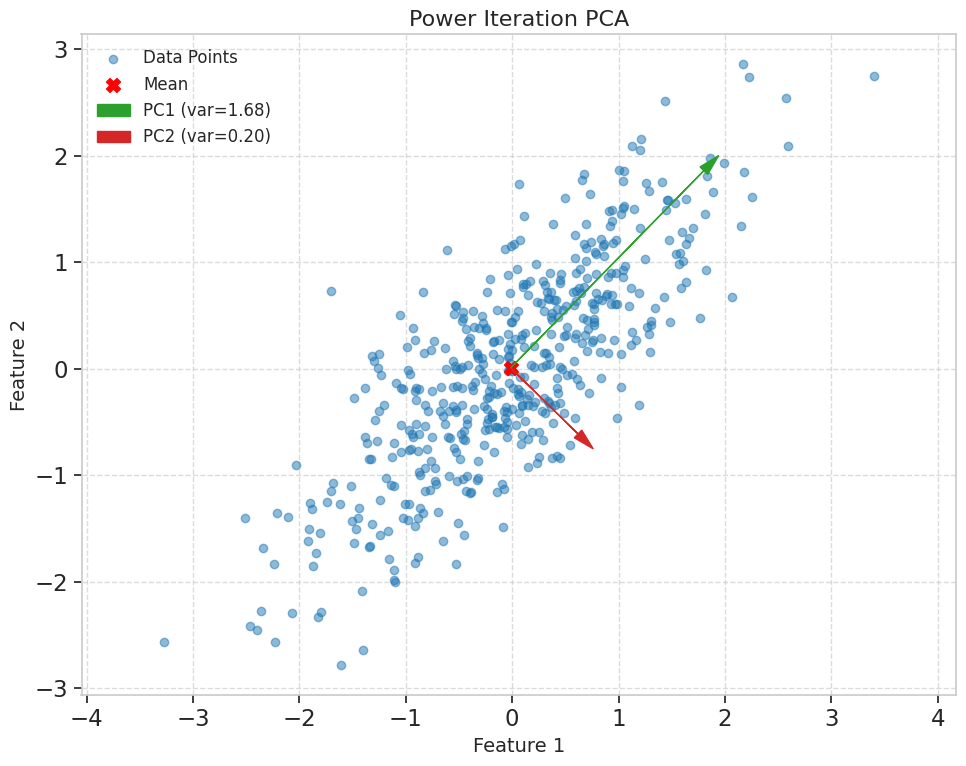

In [15]:
# Generate a synthetic 2D dataset with correlation
def generate_correlated_data(n_samples=500, mean=[0, 0], cov=[[1, 0.8], [0.8, 1]]):
    """Generate a synthetic dataset with specified correlation"""
    data = np.random.multivariate_normal(mean, cov, n_samples)
    return torch.tensor(data, dtype=torch.float32)

# Generate synthetic data
data = generate_correlated_data(n_samples=500)

# Apply our power iteration PCA
components, explained_variance = power_iteration_pca(data, n_components=2)

print("Principal components found by power iteration PCA:")
print(components)
print("\nExplained variance:")
print(explained_variance)

# Compare with torch's built-in SVD-based PCA
U, S, V = torch.svd(data - data.mean(dim=0, keepdim=True))
print("\nPrincipal components found by SVD:")
print(V.T[:2])
print("\nSingular values squared:")
sv_squared = [(s**2).item() / (data.shape[0] - 1) for s in S[:2]]
print(sv_squared)

# Visualize the dataset and principal components
plt.figure(figsize=(10, 8))

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data Points')

# Plot the mean as a red X
mean = data.mean(dim=0)
plt.scatter(mean[0], mean[1], color='red', s=100, marker='X', label='Mean')

# Scale the components for visualization
scale = 2
for i, (comp, var) in enumerate(zip(components, explained_variance)):
    plt.arrow(mean[0], mean[1], 
              scale * np.sqrt(var) * comp[0],
              scale * np.sqrt(var) * comp[1],
              head_width=0.1, head_length=0.2, fc=f'C{i+2}', ec=f'C{i+2}',
              label=f'PC{i+1} (var={var:.2f})')

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Power Iteration PCA', fontsize=16)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.legend(fontsize=12)
plt.axis('equal')
plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've explored various power iteration methods for computing eigenvalues and eigenvectors:

1. **Basic Power Method**: Finds the eigenvalue with largest magnitude
2. **Inverse Power Method**: Finds the eigenvalue with smallest magnitude
3. **Shifted Power Method**: Finds eigenvalues close to a specified shift
4. **Rayleigh Quotient Iteration**: Rapidly converges to an eigenvalue by dynamically updating the shift

We've also seen how these methods can be applied to practical problems like Principal Component Analysis.

The key advantages of these iterative methods are:
- They only require matrix-vector products, which are cheap for sparse matrices
- They allow us to compute specific eigenvalues without full eigendecomposition
- They can be terminated early for approximate solutions

For large-scale problems in data science, machine learning, and scientific computing, these power methods provide efficient ways to compute the most important eigenvalues and eigenvectors.